# Waterhackweek 2020 Project - SnowGW: basin water budget components

Based off of original code by [Emilio Mayorga](https://github.com/emiliom), University of Washington &mdash; [WaterHackWeek 2020](https://waterhackweek.github.io/). See Emilio's original script [mashup_waterbudget.ipynb](https://github.com/waterhackweek/waterdata/blob/master/mashup_waterbudget.ipynb) for helpful information on data sources, packages, and functions.

## Goal

* Construct time series visualizations at daily and/or monthly timescales that show water budget components for basins with snow-groundwater dynamics of interest. (Interim)

## Objective

**Construct and analyze (sub)watershed-scale water budget components for the two example watersheds using geospatial watershed layers and a wide variety of water data, including:**

* HUC8 basin boundaries (and associated HUC10 and HUC12 sub-basins)
* Daymet precipitation and SWE (gridded, daily)
* MODIS SSEBop evapotranspiration (gridded, monthly)
* GRACE water storage anomalies (gridded, monthly)
* USGS NWIS discharge (point, daily)
* USGS groundwater level measurements (point, daily)
* SNOTEL SWE (point, daily)

## Cases
                                                  
**Clackamas, OR**
* HUC-8 Subbasin ID 17090011
* size 2442 km^2
* slope 24.2%
* Total stream length (km) 1810.4 km
* Land cover: evergreen forest (73%), shrub/scrub (10%)

**Upper South Platte, CO**
* HUC-8 Subbasin ID 10190002 
* size: 4,797 km²
* slope: 22.3%
* Total stream length (km) 2812.4 km
* Land cover: evergreen forest (50%), shrub/ scrub: 18%, grassland: 15%

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Setup</b></br>
</div>

## Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import contextily as cx
import folium

import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm

from shapely.geometry import box
import pynhd as nhd
import pygeoogc as geoogc
import pygeoutils as geoutils
import hydrodata as hd

## Set the time period

To be reused with every dataset.

In [2]:
date_start = '2015-10-1'
date_end = '2016-09-30'

## Select basin

Select one of the case study basins' HUC8 codes (OR: `17090011`; CO: `10190002`)

We'll use the shorthand "sb" to refer to the "selected basin".

In [3]:
#sb_huc08code = '10190002'

sb_huc08code = '17090011'

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Format basin</b></br>
</div>

### Create HUC10 subwatersheds by first reading HUC12 subwatersheds

Request all HUC12 watersheds whose HUC12 code includes the sb code.

In [4]:
def wfs_getfeatures_cqlfilter(wd, cql_filter=None):
    """
    Use hydrodata packages to issue and process a OpenGeospatial Consortium (OGC) Web Feature Service (WFS) 
    request for WBD watersheds, with an optional filter to obtain only the watersheds we want.
    Returns a nice and clean GeoPandas GeoDataframe in "lat-lon" projection (epsg:4326)
    """
    payload = {
        "service": "wfs",
        "request": "GetFeature",
        "version": wd.version,
        "outputFormat": wd.outformat,
        "typeName": wd.layer,
    }
    if type(cql_filter) is str:
        payload["cql_filter"] = cql_filter

    r = geoogc.RetrySession().get(wd.url, payload)
    
    return geoutils.json2geodf(r.json(), "epsg:4326", crs="epsg:4326")

In [5]:
sb_wdhuc12 = nhd.WaterData('huc12', crs='epsg:4269')

In [6]:
print(sb_wdhuc12.get_validnames())

['huc12', 'tohuc', 'areaacres', 'areasqkm', 'name', 'hutype', 'humod', 'states', 'noncontrib', 'bbox']


In [7]:
# HUC filter (cql_filter) will be the string "huc12 LIKE '17030001%'"
sb_huc12_gdf = wfs_getfeatures_cqlfilter(
    sb_wdhuc12, 
    cql_filter=f"huc12 LIKE '{sb_huc08code}%'"
)

sb_huc12_gdf.head(2)

,geometry,huc12,tohuc,areaacres,areasqkm,name,hutype,humod,states,noncontrib,bbox
0,"MULTIPOLYGON (((-122.11810 44.87790, -122.1171...",170900110101,170900110103,10218.364276,41.352253,Upper Hot Springs Fork Collawash River,S,NM,OR,0,"[-122.2082, 44.8645, -122.1162, 44.9536]"
1,"MULTIPOLYGON (((-121.81240 44.81170, -121.8163...",170900110201,170900110203,14882.940694,60.229124,Cub Creek,S,NM,OR,0,"[-121.956, 44.8004, -121.8123, 44.9064]"


Create `huc10` column from `huc12` codes.

In [8]:
sb_huc12_gdf['huc10'] = sb_huc12_gdf.huc12.str[:-2]
cols = ['huc10', 'areasqkm', 'geometry']
sb_huc10_gdf = sb_huc12_gdf[cols].dissolve(by='huc10', aggfunc='sum', as_index=False)

len(sb_huc10_gdf)

6

In [9]:
sb_huc10_gdf.head(2)

,huc10,geometry,areasqkm
0,1709001101,"POLYGON ((-122.01470 44.84950, -122.01990 44.8...",394.544996
1,1709001102,"POLYGON ((-121.81240 44.81170, -121.81630 44.8...",408.515994


Use the `total_bounds` GeoDataFrame function to extract the outer bounding box coordinates, then create a simple GeoSeries out of that rectangle for reuse later on.

In [10]:
sb_huc10_gdf.total_bounds

array([-122.6089,   44.8004, -121.6515,   45.4562])

In [11]:
sb_bbox = gpd.GeoSeries(box(*sb_huc10_gdf.total_bounds), crs=sb_huc10_gdf.crs)

Set `xarray` spatial (lat & lon) "slices" here, for reuse below when doing lat-lon region clipping (via the `.sel` method) of `xarray` datasets.

In [12]:
sb_lon_slice = slice(sb_bbox.bounds.minx[0], sb_bbox.bounds.maxx[0])
sb_lat_slice = slice(sb_bbox.bounds.miny[0], sb_bbox.bounds.maxy[0])

Plot HUC8 basin + HUC10 sub-basins

In [13]:
# Note: There are other basemap tiles besides StamenTerrain
m = folium.Map(tiles='StamenTerrain', attr='ESRI')

In [14]:
# Bounding box
folium.GeoJson(
    sb_bbox.geometry,
    style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
).add_to(m)

# Set the map extent (bounds) to the extent of the bounding box
m.fit_bounds(m.get_bounds())

# HUC10 sub-watershed polygons
for i, i_gdf in sb_huc10_gdf.iterrows():
    folium.GeoJson(
        i_gdf.geometry,
        style_function=lambda feature: {'color': 'black', 'fillOpacity': 0.0},
        tooltip=i_gdf['huc10']
    ).add_child(
        folium.Popup(f"<b>HUC10:</b><br> {i_gdf['huc10']}<br><b>watershed area:</b><br> {i_gdf['areasqkm']:.0f} km^2")
    ).add_to(m)

In [15]:
m

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Read data, and extract over selection (time and basin) </b></br>
</div>

## Precipitation and SWE from DayMet

### Get metadata ("lazy loading")

In [16]:
daymet_opendap_url = "https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml"
    
daymet_ds = xr.open_dataset(daymet_opendap_url)

### Get the selected basin bounding box in the DayMet projection coordinates

In [17]:
daymet_ds_grid_mapping_name = 'lambert_conformal_conic'

In [18]:
# DayMet crs information is in: ds.lambert_conformal_conic ('lcc')
lcc_crs = CRS.from_cf(daymet_ds[daymet_ds_grid_mapping_name].attrs)

In [19]:
# Reproject our bounding box polygon into this new coordinate system, to use in our request
sb_bbox_lcc = sb_bbox.to_crs(lcc_crs)

In [20]:
sb_lcc_bnd = sb_bbox_lcc.bounds

### Get the DayMet data for the selected XYT "cube"

In [21]:
sb_daymet_da = daymet_ds.sel(
    time=slice(date_start, date_end),
    x=slice(sb_lcc_bnd.minx[0], sb_lcc_bnd.maxx[0]),
    y=slice(sb_lcc_bnd.maxy[0], sb_lcc_bnd.miny[0]) # note the reversed y values!
)

In [22]:
sb_daymet_da

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 366, x: 88, y: 86)
Coordinates:
  * x                        (x) float32 -1685250.0 -1684250.0 ... -1598250.0
  * y                        (y) float32 540000.0 539000.0 ... 456000.0 455000.0
  * time                     (time) datetime64[ns] 2015-10-01 ... 2016-09-30
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

Select precipitation and SWE

In [23]:
sb_daymet_da_prcp = sb_daymet_da.prcp
sb_daymet_da_swe = sb_daymet_da.swe

In [24]:
sb_daymet_da_prcp

<xarray.DataArray 'prcp' (time: 366, y: 86, x: 88)>
[2769888 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1685250.0 -1684250.0 ... -1599250.0 -1598250.0
  * y        (y) float32 540000.0 539000.0 538000.0 ... 456000.0 455000.0
  * time     (time) datetime64[ns] 2015-10-01 2015-10-02 ... 2016-09-30
    lat      (y, x) float32 45.404533 45.40708 45.40963 ... 44.84365 44.84605
    lon      (y, x) float32 -122.847206 -122.83431 ... -121.44424 -121.43141
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

In [25]:
sb_daymet_da_swe

<xarray.DataArray 'swe' (time: 366, y: 86, x: 88)>
[2769888 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1685250.0 -1684250.0 ... -1599250.0 -1598250.0
  * y        (y) float32 540000.0 539000.0 538000.0 ... 456000.0 455000.0
  * time     (time) datetime64[ns] 2015-10-01 2015-10-02 ... 2016-09-30
    lat      (y, x) float32 45.404533 45.40708 45.40963 ... 44.84365 44.84605
    lon      (y, x) float32 -122.847206 -122.83431 ... -121.44424 -121.43141
Attributes:
    long_name:     snow water equivalent
    units:         kg/m2
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: mean

### Reproject to lat-lon (to use with other data)

In [26]:
def reproject_da_as_ds(da, from_grid_mapping_name, from_crs, to_crs):
    """
    Reproject an xarray DataArray using rioxarray and the expectation of CF convention 
    for projection information.
    This function is fairly generic and can be reused with other datasets with only small changes.
    Returns an xarray DataSet with the expected, CF-convention projection information.
    """
    ds = da.to_dataset()
    # Use rioxarray to improve (clean up) the CRS metadata, 
    # so it can be used in the reprojection step
    ds.rio.write_crs(from_crs.to_string(), inplace=True)
    
    # Reproject the xarray dataset
    # Note: the drop_vars step could be done outside this function, since it's source-data cleanup
    reproj_ds = (
        ds
        .drop_vars(['lon', 'lat'])
        .rio.reproject(to_crs)
    )
    
    # Clean up the projection information and coordinates of the reprojected dataset
    to_grid_mapping_name = reproj_ds[from_grid_mapping_name].attrs['grid_mapping_name']
    reproj_ds = (
        reproj_ds
        .rio.set_spatial_dims('x', 'y')
        .rio.write_crs(to_crs)
        .rename({"x": "lon", "y": "lat", from_grid_mapping_name: to_grid_mapping_name}) 
        # this last step applies only when reprojecting to lat-lon
    )
    reproj_ds.attrs['grid_mapping'] = to_grid_mapping_name
    reproj_ds[da.name].attrs['grid_mapping'] = to_grid_mapping_name
    
    return reproj_ds

In [27]:
sb_daymet_ds_prcp = reproject_da_as_ds(sb_daymet_da_prcp, daymet_ds_grid_mapping_name, lcc_crs, "epsg:4326")
sb_daymet_ds_swe = reproject_da_as_ds(sb_daymet_da_swe, daymet_ds_grid_mapping_name, lcc_crs, "epsg:4326")

Quick check on the resulting cell sizes, in degrees

In [28]:
def print_cellsizes(dimcoord):
    print(dimcoord.values[1] - dimcoord.values[0], dimcoord.values[-1] - dimcoord.values[-2])

In [29]:
print_cellsizes(sb_daymet_ds_prcp.lon)
print_cellsizes(sb_daymet_ds_swe.lon)

0.012512596453134961 0.012512596453134961
0.012512596453134961 0.012512596453134961


In [30]:
print_cellsizes(sb_daymet_ds_prcp.lat)
print_cellsizes(sb_daymet_ds_swe.lat)

-0.012512596453142066 -0.012512596453142066
-0.012512596453142066 -0.012512596453142066


Clip to basin polygon boundary

In [31]:
sb_daymet_ds_prcp = sb_daymet_ds_prcp.rio.clip(sb_huc10_gdf.geometry, all_touched=True)
sb_daymet_ds_swe = sb_daymet_ds_swe.rio.clip(sb_huc10_gdf.geometry, all_touched=True)

Look ("5th time step from the end")

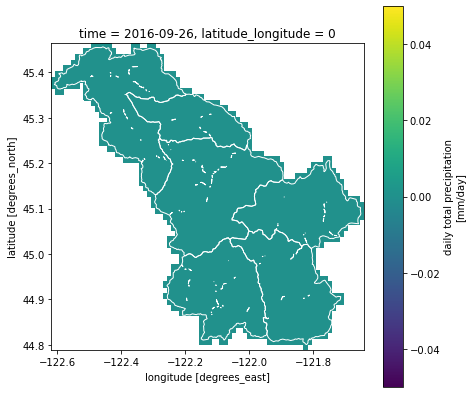

In [32]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_daymet_ds_prcp.prcp.isel(time=-5).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

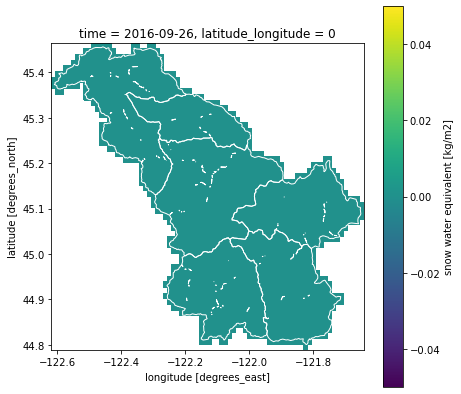

In [33]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_daymet_ds_swe.swe.isel(time=-5).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

## ETa from MODIS SSEBop

In [34]:
ssebop_opendap_url = "https://cida.usgs.gov/thredds/dodsC/ssebopeta/monthly"

ssebop_ds = xr.open_dataset(ssebop_opendap_url)

In [35]:
ssebop_ds

<xarray.Dataset>
Dimensions:  (lat: 2834, lon: 6612, time: 238)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-10-01
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.51 -66.51 -66.5
  * lat      (lat) float64 24.0 24.01 24.02 24.03 ... 49.47 49.48 49.49 49.5
Data variables:
    crs      |S64 ...
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time

In [36]:
ssebop_ds.rio.write_crs(CRS.from_cf(ssebop_ds['crs'].attrs), inplace=True);

In [37]:
ssebop_ds.time.values[0:3]

array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [38]:
sb_ssebop_et_ds = ssebop_ds.sel(time=slice(date_start, date_end), lon=sb_lon_slice, lat=sb_lat_slice)

sb_ssebop_et_ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 106, time: 12)
Coordinates:
  * time     (time) datetime64[ns] 2015-10-01 2015-11-01 ... 2016-09-01
    crs      int64 0
  * lon      (lon) float64 -122.6 -122.6 -122.6 -122.6 ... -121.7 -121.7 -121.7
  * lat      (lat) float64 44.81 44.82 44.82 44.83 ... 45.43 45.44 45.45 45.45
Data variables:
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time
    grid_mapping:                    crs

In [39]:
sb_ssebop_et_ds = sb_ssebop_et_ds.rio.clip(sb_huc10_gdf.geometry, all_touched=True)

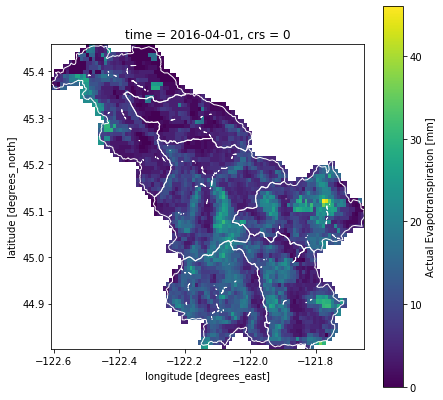

In [40]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_ssebop_et_ds.et.isel(time=6).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

## TWS anomalies from GRACE

In [41]:
grace_opendap_url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/mascon/RL06/JPL/v02/CRI/netcdf/GRCTellus.JPL.200204_202007.GLO.RL06M.MSCNv02CRI.nc"

grace_ds = xr.open_dataset(grace_opendap_url)

In [42]:
grace_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 187)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-07-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-07-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...


In [43]:
grace_ds.lon.values.min(), grace_ds.lon.values.max()

(0.25, 359.75)

**NOTE:** `lon` values are 0 - 360 (starting from the anti-meridian, "-180") rather than -180 to 180 as the previous datasets; add an offset in the lon slice specification, and shift the xarray dataset to make it work with the region mask and GeoDataFrame overlays.

In [44]:
sb_grace_lwe_thickness_ds = grace_ds.sel(
    time=slice(date_start, date_end), 
    lon=slice(360 + sb_bbox.bounds.minx[0] - 0.5, 360 + sb_bbox.bounds.maxx[0] + 0.5), 
    lat=slice(sb_bbox.bounds.miny[0] - 0.5, sb_bbox.bounds.maxy[0] + 0.5), 
)

sb_grace_lwe_thickness_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 3, lon: 4, time: 8)
Coordinates:
  * lon            (lon) float64 237.2 237.8 238.2 238.8
  * lat            (lat) float64 44.75 45.25 45.75
  * time           (time) datetime64[ns] 2015-12-23T12:00:00 ... 2016-08-21T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 44.5 45.0 45.0 45.5 45.5 46.0
    lon_bounds     (lon, bounds) float64 237.0 237.5 237.5 ... 238.5 238.5 239.0
    time_bounds    (time, bounds) datetime64[ns] 2015-12-12 ... 2016-09-03T23...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-07-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N

In [45]:
sb_grace_lwe_thickness_ds.coords['lon'] = (sb_grace_lwe_thickness_ds.coords['lon'] + 180) % 360 - 180
sb_grace_lwe_thickness_ds = sb_grace_lwe_thickness_ds.sortby(sb_grace_lwe_thickness_ds.lon)

In [46]:
sb_grace_lwe_thickness_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 3, lon: 4, time: 8)
Coordinates:
  * lon            (lon) float64 -122.8 -122.2 -121.8 -121.2
  * lat            (lat) float64 44.75 45.25 45.75
  * time           (time) datetime64[ns] 2015-12-23T12:00:00 ... 2016-08-21T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 44.5 45.0 45.0 45.5 45.5 46.0
    lon_bounds     (lon, bounds) float64 237.0 237.5 237.5 ... 238.5 238.5 239.0
    time_bounds    (time, bounds) datetime64[ns] 2015-12-12 ... 2016-09-03T23...
    lwe_thickness  (time, lat, lon) float64 8.193 8.193 8.193 ... -17.27 -17.27
    uncertainty    (time, lat, lon) float64 3.181 3.181 3.181 ... 3.906 3.906
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-07-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wies

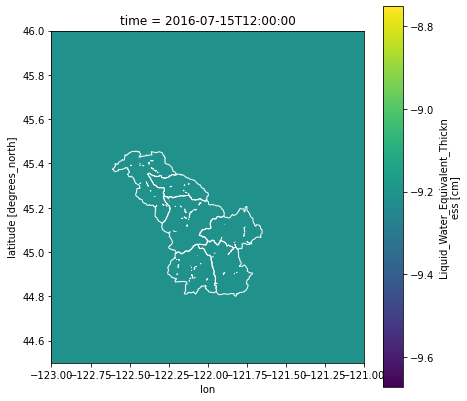

In [47]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_grace_lwe_thickness_ds.lwe_thickness.isel(time=6).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

## Discharge from USGS NWIS

Use `hydrodata.interactive_map`: for HUC10 subbasin boundaries, produce clickable site markers.

In [48]:
m2 = hd.interactive_map(tuple(sb_bbox.total_bounds))

In [49]:
for i, i_gdf in sb_huc10_gdf.iterrows():
    folium.GeoJson(
        i_gdf.geometry,
        style_function=lambda feature: {'color': 'black', 'fillOpacity': 0.0},
        tooltip=i_gdf['huc10']
    ).add_child(
        folium.Popup(f"<b>HUC10:</b><br> {i_gdf['huc10']}<br><b>watershed area:</b><br> {i_gdf['areasqkm']:.0f} km^2")
    ).add_to(m2)


m2.fit_bounds(m2.get_bounds())

In [50]:
m2

<div class="alert alert-info" style="font-size:100%">

<b>HELP?</b> would be great to have some script that allowed us to subset guages to those within the above-selected date range!
    
Right now, I'm just clicking through the pins to find a site with an appropriate date range, and then entering that site number below (`nearestoutlet_sitecode = [manually selected site]`)
    
</div>

In [51]:
nwis = hd.NWIS()

In [52]:
nearestoutlet_sitecode = '14211010'

With `mmd=True`, `nwis.get_streamflow` converts cms (cubic meters / second) to mmd (mm/day) based on the contributing drainage area of the station.

In [53]:
nwis_q_daily_ts = nwis.get_streamflow([nearestoutlet_sitecode], dates=(date_start, date_end), mmd=True)

In [54]:
nwis_q_daily_ts.head()

,USGS-14211010
dateTime,
2015-10-01,0.719449
2015-10-02,0.714439
2015-10-03,0.722455
2015-10-04,0.738488
2015-10-05,0.713437


Resample to daily and tweak it so it's consistent with the other watershed-scale time series. 

NOTE: my use of nearestoutlet_sitecode below (instead of column site name directly) might cause problems... can't tell yet because of unresolved error above

In [55]:
nwis_q_ts_df = nwis_q_daily_ts.resample('1M').sum()
nwis_q_ts_df.index = nwis_q_ts_df.index.month
nwis_q_ts_df.index.name = 'month'
nwis_q_ts_df.rename(columns={nearestoutlet_sitecode: 'disch'}, inplace=True)

nwis_q_ts_df

,USGS-14211010
month,
10,24.794948
11,102.466412
12,290.645486
1,176.746043
2,176.204953
3,192.026825
4,112.005628
5,66.063080
6,42.405423


## Groundwater level from USGS

In [56]:
sb_gw = pd.read_csv("data/ORgw.csv")

In [57]:
sb_gw.rename(columns={'116034_72019_00003': 'gw'}, inplace=True)

In [63]:
sb_gw.dtypes

agency_cd                        object
site_no                           int64
datetime                 datetime64[ns]
gw                              float64
116034_72019_00003_cd            object
dtype: object

In [59]:
sb_gw.head()

,agency_cd,site_no,datetime,gw,116034_72019_00003_cd
0,USGS,452033122195901,2001-09-07,63.97,A
1,USGS,452033122195901,2001-09-08,63.84,A
2,USGS,452033122195901,2001-09-09,63.70,A
3,USGS,452033122195901,2001-09-10,63.85,A
4,USGS,452033122195901,2001-09-11,63.95,A


In [62]:
sb_gw['datetime'] =  pd.to_datetime(sb_gw['datetime'], format='%Y-%m-%d')
sb_gw.head()

,agency_cd,site_no,datetime,gw,116034_72019_00003_cd
0,USGS,452033122195901,2001-09-07,63.97,A
1,USGS,452033122195901,2001-09-08,63.84,A
2,USGS,452033122195901,2001-09-09,63.70,A
3,USGS,452033122195901,2001-09-10,63.85,A
4,USGS,452033122195901,2001-09-11,63.95,A


In [71]:
sb_gw=sb_gw.set_index(sb_gw.datetime)

In [74]:
sb_gw=sb_gw.loc[slice(date_start,date_end)]
sb_gw

,agency_cd,site_no,datetime,gw,116034_72019_00003_cd
datetime,,,,,
2015-10-01,USGS,452033122195901,2015-10-01,63.64,A
2015-10-02,USGS,452033122195901,2015-10-02,63.76,A
2015-10-03,USGS,452033122195901,2015-10-03,63.57,A
2015-10-04,USGS,452033122195901,2015-10-04,63.48,A
2015-10-05,USGS,452033122195901,2015-10-05,63.50,A
...,...,...,...,...,...
2016-09-26,USGS,452033122195901,2016-09-26,63.97,A
2016-09-27,USGS,452033122195901,2016-09-27,64.05,A
2016-09-28,USGS,452033122195901,2016-09-28,64.01,A


## SWE from SNOTEL

Import directly from separately downloaded data...?

In [96]:
snow_stn = pd.read_csv("data/OR_DB.csv",dtype={'huc8':object})
snow_stn

,Unnamed: 0,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2,dem_elev,slope,aspect,pr
0,0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.520020,POINT (-117.1925811767578 45.21327972412109),170601050101,1706010501,17060105,170601,1706,17,2256,89.991560,263.659820,3.310440
1,1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.848022,POINT (-122.1651763916016 42.87007141113281),180102030101,1801020301,18010203,180102,1801,18,1835,89.995480,186.788970,6.601648
2,2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696045,POINT (-119.2539215087891 45.19084930419922),170702020604,1707020206,17070202,170702,1707,17,1770,89.975845,18.434948,1.412088
3,3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656006,POINT (-122.0938034057617 44.32529830932617),170900040203,1709000402,17090004,170900,1709,17,1444,89.996216,103.760790,6.565934
4,4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.663940,POINT (-116.9809722900391 44.60533142089844),170501241001,1705012410,17050124,170501,1705,17,1882,89.995110,189.582950,3.395604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,108,821_OR_SNTL,-118.426170,44.655670,Tipton,1569.719971,POINT (-118.4261703491211 44.65567016601562),170502020101,1705020201,17050202,170502,1705,17,1578,89.982740,288.434940,2.148352
107,109,1044_OR_SNTL,-122.425369,43.227180,Toketee Airstrip,987.552002,POINT (-122.4253692626953 43.22718048095703),171003010404,1710030104,17100301,171003,1710,17,988,89.975550,309.805570,4.192308
108,110,824_WA_SNTL,-117.850502,46.118679,Touchet,1685.543945,POINT (-117.8505020141602 46.11867904663086),170701020303,1707010203,17070102,170701,1707,17,1686,89.980606,336.037500,3.472527
109,111,1007_OR_SNTL,-121.916672,45.433331,Usfs Nanny Creek,853.440002,POINT (-121.9166717529297 45.43333053588867),170800010501,1708000105,17080001,170800,1708,17,1062,89.999070,150.376250,2.857143


In [107]:
stn=snow_stn[snow_stn.huc8 == sb_huc08code]
stn

,Unnamed: 0,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2,dem_elev,slope,aspect,pr
16,16,398_OR_SNTL,-121.754433,45.096581,Clackamas Lake,1036.319946,POINT (-121.7544326782227 45.09658050537109),170900110301,1709001103,17090011,170900,1709,17,1056,89.99585,55.619656,2.489011
68,70,687_OR_SNTL,-121.932518,45.041481,Peavine Ridge,1042.416016,POINT (-121.9325180053711 45.04148101806641),170900110306,1709001103,17090011,170900,1709,17,1058,89.97413,298.300750,2.653846


In [109]:
import ulmo
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df


In [110]:
stn_swe = pd.DataFrame(index=pd.date_range(start=date_start, end=date_end))
for sitecode in stn.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=date_start, end_date=date_end)
        stn_swe[sitecode] = swe.value
    except:
        print(sitecode, 'has no data')
        stn_swe[sitecode] = np.nan

398_OR_SNTL SNOTEL:WTEQ_D 2015-10-1 2016-09-30
687_OR_SNTL SNOTEL:WTEQ_D 2015-10-1 2016-09-30


In [111]:
stn_swe

,398_OR_SNTL,687_OR_SNTL
2015-10-01,0.0,0.0
2015-10-02,0.0,0.0
2015-10-03,0.0,0.0
2015-10-04,0.0,0.0
2015-10-05,0.0,0.0
...,...,...
2016-09-26,0.0,0.0
2016-09-27,0.0,0.0
2016-09-28,0.0,0.0
2016-09-29,0.0,0.0


In [ ]:
sb_daymet_ds_prcp = sb_daymet_ds_prcp.rio.clip(sb_huc10_gdf.geometry, all_touched=True)
sb_daymet_ds_swe

In [113]:
data  = sb_daymet_ds_swe.sel_points(lon=lon, lat=lat, method='nearest')
ts_dataframe = data[vars].to_dataframe()
ts_dataframe

AttributeError: 'Dataset' object has no attribute 'sel_points'

In [119]:
for i in range(len(sb_daymet_ds_swe.time)):
    sb_daymet_ds_swe.time[i].sel(x=stn.geometry.x, y=stn.geometry.y, method='nearest').values[0]

AttributeError: 'Series' object has no attribute 'x'

In [ ]:
gdf['pr']= daymet_mean.sel(x=reproj_gdf.geometry.x, y=reproj_gdf.geometry.y, method='nearest').values[0]

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Generate basin time series means using basin regions and mask (HUC10-level) </b></br>

### Create `regionmask` regions from a GeoDataFrame

<b>REGIONMASK LIMITATION:</b> <a href="https://github.com/mathause/regionmask/issues/151">regionmask is hard-wired to work only with data in lat-lon coordinates!</a>
</div>

In [57]:
sb_huc10_regions = rm.from_geopandas(
    sb_huc10_gdf, names="huc10", name="huc10"
)

sb_huc10_regions

<regionmask.Regions>
Name:     huc10

Regions:
 0  r0  1709001101
 1  r1  1709001102
 2  r2  1709001103
 3  r3  1709001104
 4  r4  1709001105
 5  r5  1709001106

[6 regions]

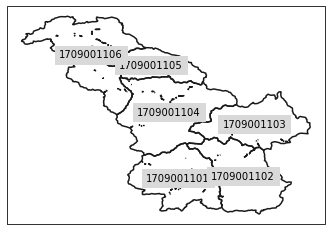

In [58]:
sb_huc10_regions.plot(label="name");

### HUC10 watershed time series means

In [ ]:
def generate_huc10_ts(regions, ds, dsvarname, crsvar=None):
    """
    Use regionmask to create a gridded mask from the regions and the xarray dataset's
    grid resolution. Copy the variable attributes from the source DataSet to the 
    output DataArray.
    Returns a DataArray
    """
    mask3d = regions.mask_3D(ds, drop=False)

    # Latitude weighting for area-weighted averaging.
    # But it's probably unnecessary for this small geographical extent of the Upper Yakima
    weights = np.cos(np.deg2rad(ds.lat))
    regions_ts = ds[dsvarname].weighted(mask3d * weights).mean(dim=("lat", "lon"))
    # Assign dataarray name, and variable long name and units to region_ts, from ds[dsvarname]
    regions_ts.name = dsvarname
    regions_ts.attrs['long_name'] = ds[dsvarname].attrs['long_name']
    regions_ts.attrs['units'] = ds[dsvarname].attrs['units']
    
    # if present, drop crs variable b/c it's not needed anymore
    if crsvar in ds:
        regions_ts = regions_ts.drop_vars(crsvar)
    
    return regions_ts

#### Precipitation and SWE

In [ ]:
daymet_prcp_regions_ts_daily = generate_huc10_ts(sb_huc10_regions, sb_daymet_ds_prcp, 'prcp', crsvar='latitude_longitude')
daymet_swe_regions_ts_daily = generate_huc10_ts(sb_huc10_regions, sb_daymet_ds_swe, 'swe', crsvar='latitude_longitude')

Since this dataset is at a daily resolution, **aggregate (sum) to monthly resolution.** Update the variable attributes on the new DatArray, to reflect the monthly resolution. Then let's look at the HUC10 watershed averages, for both monthly and daily scales.

In [ ]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
daymet_prcp_regions_ts.plot(ax=ax1, hue="region")
ax1.set_title('Monthly')
daymet_prcp_regions_ts_daily.plot(ax=ax2, hue="region")
ax2.set_title('Daily');